In [1]:
!nvidia-smi


Sun Dec  3 17:33:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.2 MB/s eta 0:00:00


In [4]:
# Import necessary libraries and modules
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization, MaxPool2D, Input
from tensorflow.keras.saving import load_model
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')



/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Yp3RK5raZJ7EW8cRulik")
project = rf.workspace("new-workspace-onq0e").project("covid-x-ray-images")
dataset = project.version(1).download("folder")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstal

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Covid-X-ray-Images-1 in folder:: 100%|██████████| 21118/21118 [00:02<00:00, 9412.27it/s]


In [6]:
rf = Roboflow(api_key="Yp3RK5raZJ7EW8cRulik")
project = rf.workspace("joseph-nelson").project("covid-19-and-pneumonia-scans")
dataset = project.version(1).download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to COVID-19-and-Pneumonia-Scans-1 in folder:: 100%|██████████| 5889/5889 [00:01<00:00, 3763.76it/s]


In [7]:
rf = Roboflow(api_key="Yp3RK5raZJ7EW8cRulik")
project = rf.workspace("umar-farooq").project("classification-kdgyu")
dataset = project.version(1).download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to classification-1 in folder:: 100%|██████████| 12781/12781 [00:03<00:00, 3668.71it/s]


In [8]:
# Define your source and destination directories
source_directories = [
    "/content/Covid-X-ray-Images-1/test/COVID",
    "/content/Covid-X-ray-Images-1/train/COVID",
    "/content/classification-1/train/COVID-19"
]

destination_directory = "/content/combined_covid-19"

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Loop through source directories and copy their contents to the destination directory
for source_dir in source_directories:
    for filename in os.listdir(source_dir):
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_directory, filename)
        shutil.copy(source_path, destination_path)

# Optionally, you can print the number of files copied
file_count = len(os.listdir(destination_directory))
print(f"Combined {file_count} files into {destination_directory}")


Combined 8127 files into /content/combined_covid-19


In [9]:
# Define your source directories
source_directories = [
    "/content/COVID-19-and-Pneumonia-Scans-1/train/healthy",
    "/content/classification-1/train/Normal",
    "/content/Covid-X-ray-Images-1/test/Normal",
    "/content/Covid-X-ray-Images-1/train/Normal"
]

destination_directory = "/content/combined_data_normal"

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Loop through source directories and copy their contents to the destination directory
for source_dir in source_directories:
    for filename in os.listdir(source_dir):
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_directory, filename)
        shutil.copy(source_path, destination_path)

# Optionally, you can print the number of files copied
file_count = len(os.listdir(destination_directory))
print(f"Combined {file_count} files into {destination_directory}")


Combined 16008 files into /content/combined_data_normal


In [10]:
# Define your source directories
source_directories = [
    "/content/COVID-19-and-Pneumonia-Scans-1/train/pneumonia",
    "/content/Covid-X-ray-Images-1/train/Viral_Pneumonia",
    "/content/Covid-X-ray-Images-1/test/Viral_Pneumonia"
]

destination_directory = "/content/combined_data_pneumonia"

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Loop through source directories and copy their contents to the destination directory
for source_dir in source_directories:
    for filename in os.listdir(source_dir):
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_directory, filename)
        shutil.copy(source_path, destination_path)

# Optionally, you can print the number of files copied
file_count = len(os.listdir(destination_directory))
print(f"Combined {file_count} files into {destination_directory}")


Combined 5061 files into /content/combined_data_pneumonia


In [11]:
# Directory paths
combined_covid19_directory = "/content/combined_covid-19"
combined_data_normal_directory = "/content/combined_data_normal"
combined_data_pneumonia_directory = "/content/combined_data_pneumonia"
destination_directory = "/content/data"

# Create the main "data" directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Function to copy a random set of files from a source directory to the destination
def copy_random_files(source_directory, destination_subdirectory, num_files):
    subdirectory_path = os.path.join(destination_directory, destination_subdirectory)
    if not os.path.exists(subdirectory_path):
        os.makedirs(subdirectory_path)

    filenames = os.listdir(source_directory)
    random_files = random.sample(filenames, num_files)
    for filename in random_files:
        source_path = os.path.join(source_directory, filename)
        destination_path = os.path.join(subdirectory_path, filename)
        shutil.copy(source_path, destination_path)

# Copy 5,000 random files from each combined directory to their respective subfolders within the "data" directory
copy_random_files(combined_covid19_directory, "covid19", 5000)
copy_random_files(combined_data_normal_directory, "normal", 5000)
copy_random_files(combined_data_pneumonia_directory, "pneumonia", 5000)

# Optionally, you can print a message indicating the operation was successful
print("Successfully copied 5,000 random files into subfolders in the 'data' directory.")


Successfully copied 5,000 random files into subfolders in the 'data' directory.


In [12]:
pip install split-folders

In [13]:
import splitfolders

#Split data to (Train,val,test)
splitfolders = splitfolders.ratio('/content/data', output="/content/data_split", seed=42, ratio=(.7, .2, .1),group_prefix=None) # default values

Copying files: 15000 files [00:02, 5953.76 files/s]


In [14]:
!pip install tensorflow


In [15]:
from keras.preprocessing.image import ImageDataGenerator

input_shape = (260,260,3)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    horizontal_flip =True,
    vertical_flip = True ,
    fill_mode ='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

train_generator = train_datagen.flow_from_directory(
    '/content/data_split/train',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='training',
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/data_split/val',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
)


test_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

test_generator = test_datagen.flow_from_directory(
    '/content/data_split/test',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False to maintain the order
)


Found 10500 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [16]:
class_indices = train_generator.class_indices
labels = {value: key for key, value in class_indices.items()}

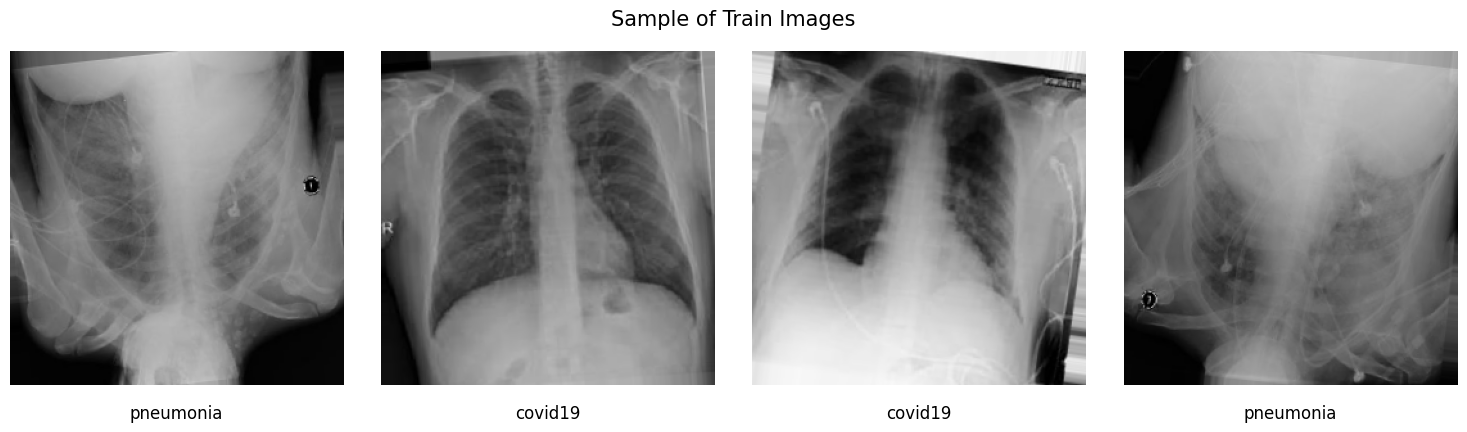

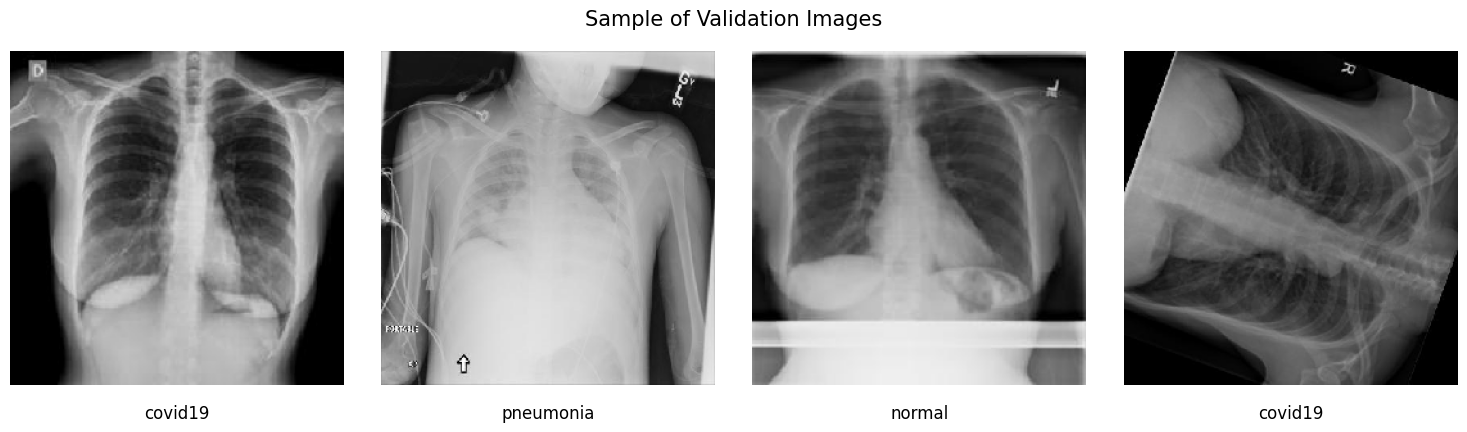

In [17]:
def showthem(subset='train'):
    plt.figure(figsize=(15, 4))
    gen = train_generator  if subset=='train' else validation_generator
    title = 'Sample of Train Images' if subset=='train' else 'Sample of Validation Images'
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        img, label = gen.next()
        plt.imshow(img[0])

        # Add text label
        plt.text(0.5, -0.1, f"{labels[np.argmax(label[0])]}", transform=plt.gca().transAxes, fontsize=12, ha='center')
        plt.axis('off')
    plt.suptitle(title,size=15)
    plt.tight_layout()
    plt.show()

showthem()
showthem("validation")

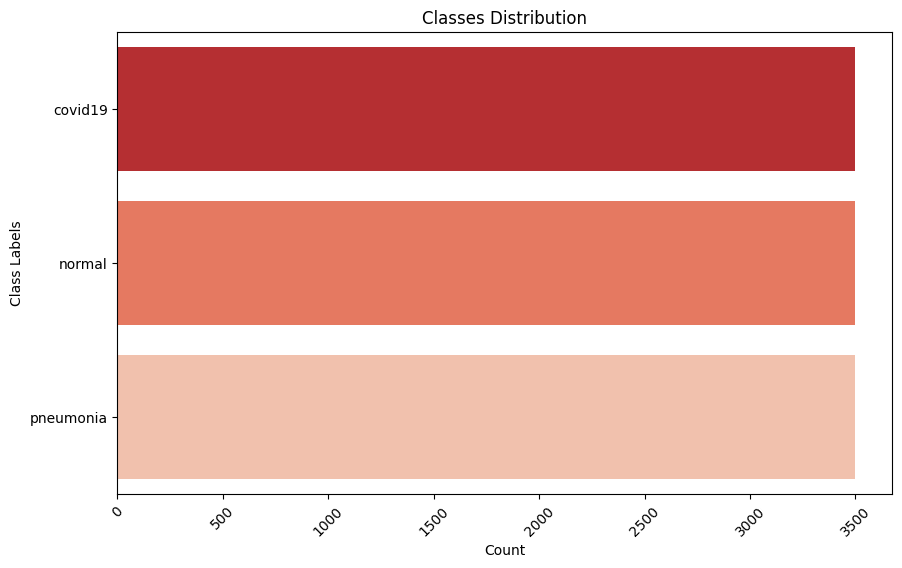

In [18]:
class_counts = train_generator.classes
class_labels = list(train_generator.class_indices.keys())
counts=[class_counts.tolist().count(i) for i in range(len(class_labels))]

dd = pd.DataFrame({'labels': class_labels, 'counts': counts})
dd = dd.sort_values(by='counts', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='counts', y='labels', data=dd, palette='Reds_r')
plt.xlabel('Count')
plt.ylabel('Class Labels')
plt.title('Classes Distribution')
plt.xticks(rotation=45)
plt.show()

In [36]:
# Define the AlexNet model
model = Sequential([
    Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(260, 260, 3)),
    MaxPooling2D((3, 3), strides=(2, 2)),
    Conv2D(256, (5, 5), padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=(2, 2)),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [37]:
# Print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 63, 63, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 31, 31, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 15, 15, 384)       885120    
                                                                 
 conv2d_8 (Conv2D)           (None, 15, 15, 384)      

In [42]:
def lr_schedule(epoch):
    initial_lr = 4.5e-5
    decrease_factor = 1.5
    if epoch >= 8:
        return initial_lr / (decrease_factor * (epoch // 8))
    return initial_lr

lr_scheduler = LearningRateScheduler(lr_schedule)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

In [43]:
# Compile the model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=[
        F1Score(num_classes=3, average='micro'), 'accuracy'
    ]
)

In [44]:
class_labels = train_generator.classes
class_weights = compute_class_weight('balanced' ,classes=np.unique(class_labels), y=class_labels)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 1.0, 1: 1.0, 2: 1.0}


In [45]:
# Inside your training loop, you can access F1 score as follows:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[lr_scheduler, checkpoint, early_stopping],
    class_weight=class_weight_dict
)


Epoch 1/100
329/329 [==============================] - ETA: 0s - loss: 0.9463 - f1_score: 0.5380 - accuracy: 0.5380
Epoch 1: val_loss improved from inf to 0.83762, saving model to best_model.h5
329/329 [==============================] - 295s 583ms/step - loss: 0.9463 - f1_score: 0.5380 - accuracy: 0.5380 - val_loss: 0.8376 - val_f1_score: 0.6213 - val_accuracy: 0.6213 - lr: 4.5000e-05
Epoch 2/100
329/329 [==============================] - ETA: 0s - loss: 0.8151 - f1_score: 0.6282 - accuracy: 0.6282
Epoch 2: val_loss improved from 0.83762 to 0.72100, saving model to best_model.h5
329/329 [==============================] - 190s 577ms/step - loss: 0.8151 - f1_score: 0.6282 - accuracy: 0.6282 - val_loss: 0.7210 - val_f1_score: 0.6777 - val_accuracy: 0.6777 - lr: 4.5000e-05
Epoch 3/100
329/329 [==============================] - ETA: 0s - loss: 0.7417 - f1_score: 0.6713 - accuracy: 0.6713
Epoch 3: val_loss improved from 0.72100 to 0.67076, saving model to best_model.h5
329/329 [=============

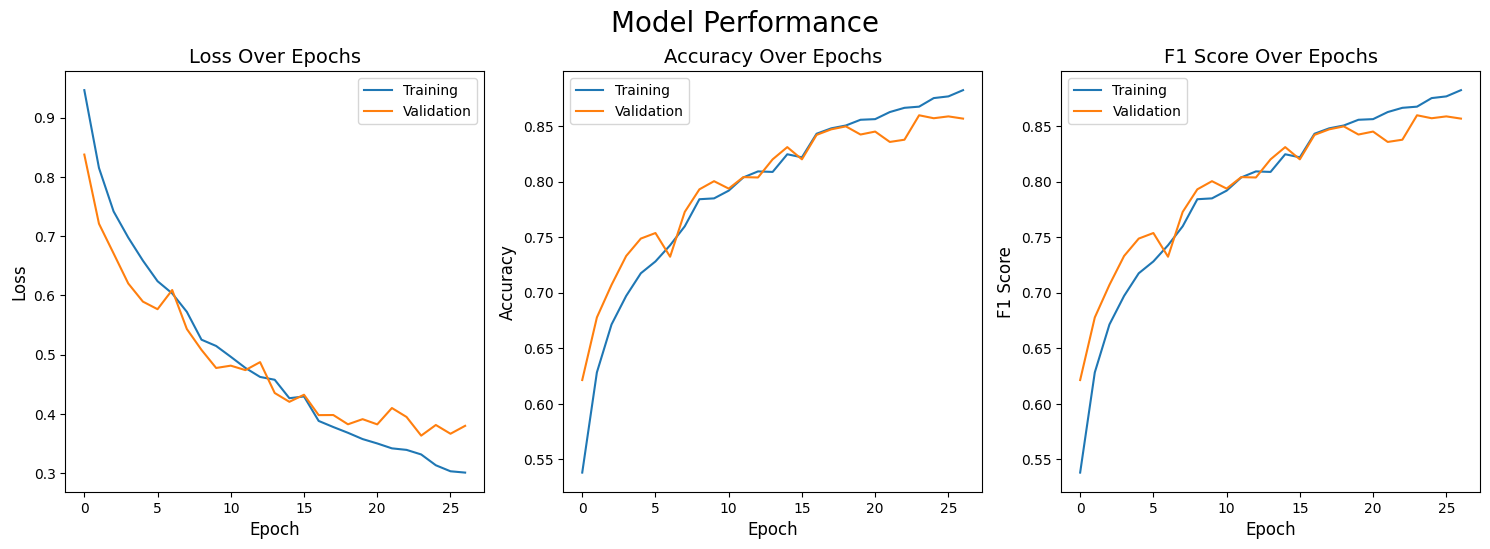

In [46]:
history_dict = history.history
metrics_to_plot = {
    'Loss': ('loss', 'val_loss'),
    'Accuracy': ('accuracy', 'val_accuracy'),
    'F1 Score': ('f1_score', 'val_f1_score')
}

plt.figure(figsize=(15, 10))

for i, (metric_name, (train_metric, val_metric)) in enumerate(metrics_to_plot.items(), 1):
    plt.subplot(2, 3, i)
    plt.plot(history_dict[train_metric], label='Training')
    plt.plot(history_dict[val_metric], label='Validation')
    plt.title(f'{metric_name} Over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.legend()

plt.suptitle('Model Performance',size=20)
plt.tight_layout()
plt.show()

In [47]:
model = load_model('best_model.h5')


In [48]:
val_set_final = validation_datagen.flow_from_directory(
    '/content/data_split/val',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3000 images belonging to 3 classes.


In [49]:
num_steps = len(val_set_final )
predictions_val = model.predict_generator(val_set_final, steps=num_steps, verbose=1)

94/94 [==============================] - 6s 60ms/step


In [50]:
val_loss ,val_acc, val_f1 = model.evaluate(val_set_final)


94/94 [==============================] - 7s 76ms/step - loss: 0.3634 - f1_score: 0.8597 - accuracy: 0.8597


In [51]:
true_labels = val_set_final.classes
predicted_labels = np.argmax(predictions_val, axis=1)
predicted_labels

array([0, 0, 0, ..., 2, 1, 1])

In [52]:
conf_mat = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
conf_mat = pd.DataFrame(conf_mat, index=validation_generator.class_indices.keys(), columns=validation_generator.class_indices.keys())

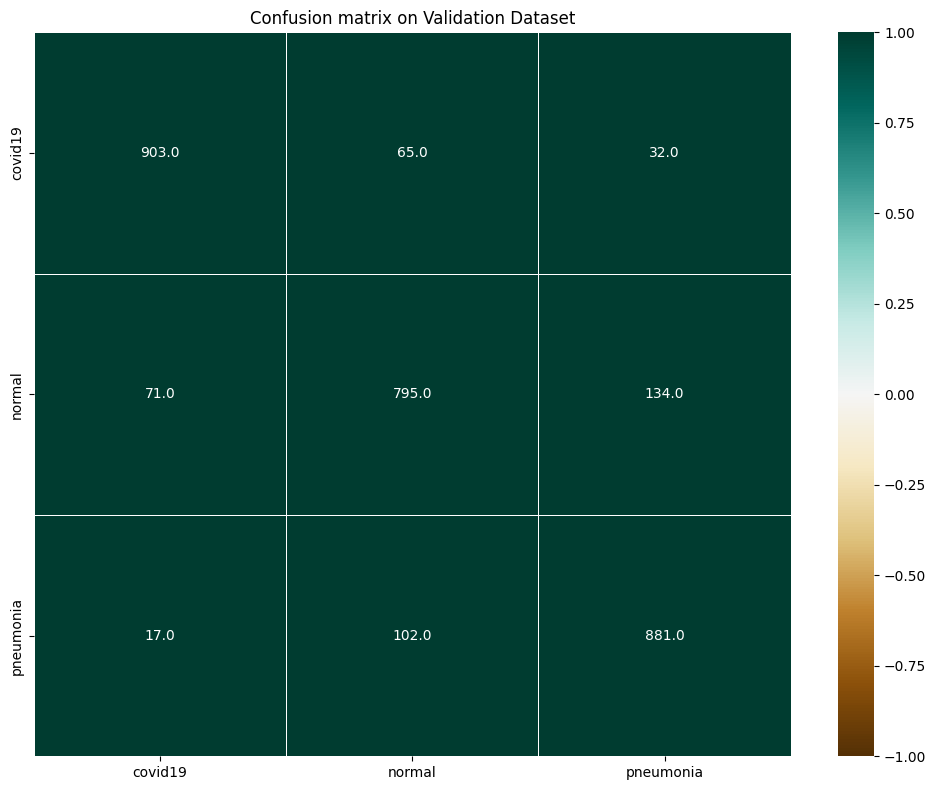

In [53]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat,ax=ax ,cmap='BrBG',center=0,vmin=-1,vmax=1,annot=True,fmt='.1f',linewidth=.5)
ax.set_title('Confusion matrix on Validation Dataset')
plt.tight_layout()
plt.show()

In [54]:
test_set_final = test_datagen.flow_from_directory(
    '/content/data_split/test',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1500 images belonging to 3 classes.


47/47 [==============================] - 3s 62ms/step


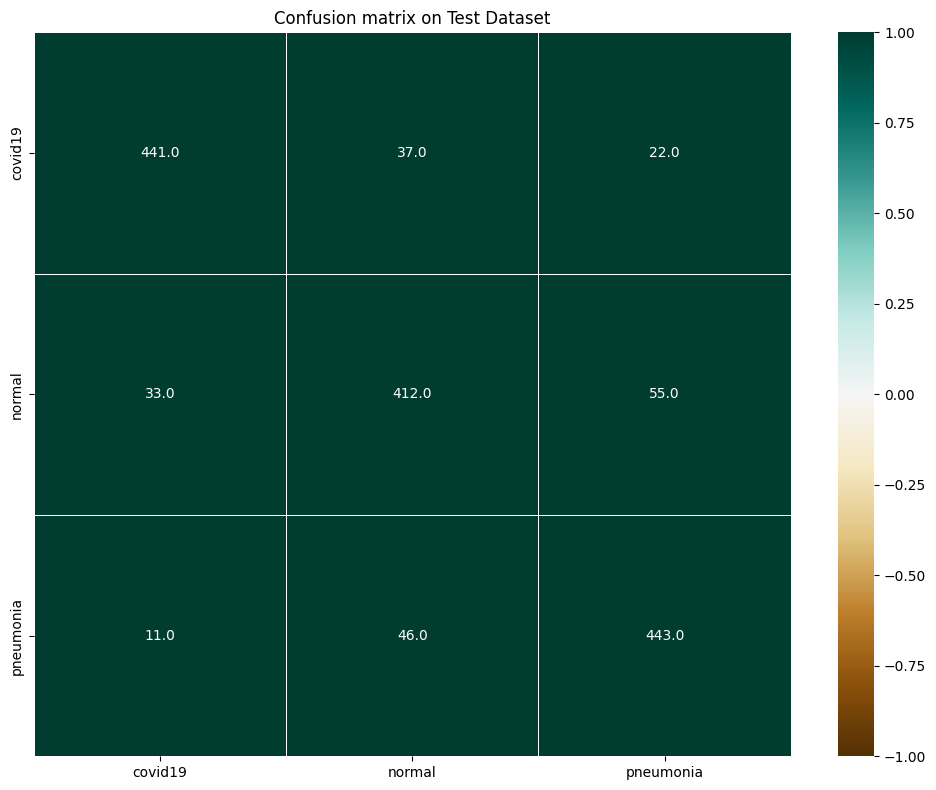

In [55]:
# Calculate loss using model.evaluate
test_loss = model.evaluate(test_set_final)

# Generate predictions for the test dataset
predictions_test = model.predict(test_set_final)

# Calculate the F1-score
true_labels = test_set_final.classes
predicted_labels = np.argmax(predictions_test, axis=1)
test_f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Create a confusion matrix
conf_mat = confusion_matrix(true_labels, predicted_labels)
conf_mat = pd.DataFrame(conf_mat, index=test_set_final.class_indices.keys(), columns=test_set_final.class_indices.keys())

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_mat, ax=ax, cmap='BrBG', center=0, vmin=-1, vmax=1, annot=True, fmt='.1f', linewidth=.5)
ax.set_title('Confusion matrix on Test Dataset')
plt.tight_layout()
plt.show()


